In [26]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from pathlib import Path
from typing import Literal
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import logging

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    roc_curve,
    auc,
)


In [28]:
def load_csv_files(folder_path):
    csv_dataframes = {}
    
    folder_path = Path(folder_path)
    for file_path in sorted(folder_path.rglob("*.csv")):
        try:
            relative_path = file_path.relative_to(folder_path)
            key_name = str(relative_path)
            
            df = pd.read_csv(file_path)
            csv_dataframes[key_name] = df
            
            print(f"Loaded: {key_name} - Shape: {df.shape}")
            
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
    
    return csv_dataframes



## AUPRC 

In [29]:
folder_path = "./models/output/pr_curves"
folder_path = "/home/gquetel/experiences-results/dataset-generation/v1/output/pr_curves"

def plot_pr_curves_from_dict(
    dataframes_dict: dict,
    output_folder_path="./models/output/pr_curves/",
    suffix: str = "",
    prevalence_value=None,
):
    fig, ax = plt.subplots(figsize=(8, 6))

    folder_path = Path(output_folder_path)
    folder_path.mkdir(exist_ok=True, parents=True)

    for filename, df in dataframes_dict.items():
        model_name = filename.replace(".csv", "")

        precision = df["precision"].values
        recall = df["recall"].values

        auprc = auc(recall, precision)
        ax.plot(recall, precision, label=f"{model_name} (AUC = {auprc:.4f})")

    if prevalence_value is not None:
        x = [0, 1]
        y = [prevalence_value] * len(x)
        ax.plot(
            x,
            y,
            "--",
            color="gray",
            alpha=0.7,
            label=f"Prevalence = {prevalence_value:.4f}",
        )

    # Customize plot
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("AUPRC Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Save plot
    output_filename = f"auprc_curves{suffix}.png"
    plt.savefig(folder_path / output_filename, dpi=300, bbox_inches="tight")
    plt.show()




In [30]:
d = load_csv_files(folder_path=folder_path)
chall_df = {}
all_df = {}

for filename, df in d.items():
    # Remove .csv extension for checking
    base_name = filename.replace(".csv", "")

    if base_name.endswith("_chall"):
        chall_df[filename] = df
    else:
        all_df[filename] = df

Loaded: CountVectorizer and RF.csv - Shape: (189, 2)
Loaded: CountVectorizer and RF_chall.csv - Shape: (126, 2)
Loaded: Manual Features and DT.csv - Shape: (28, 2)
Loaded: Manual Features and DT_chall.csv - Shape: (4, 2)
Loaded: Manual Features and RF.csv - Shape: (1454, 2)
Loaded: Manual Features and RF_chall.csv - Shape: (776, 2)
Loaded: Sentence-BERT.csv - Shape: (36204, 2)
Loaded: Sentence-BERT_chall.csv - Shape: (6920, 2)


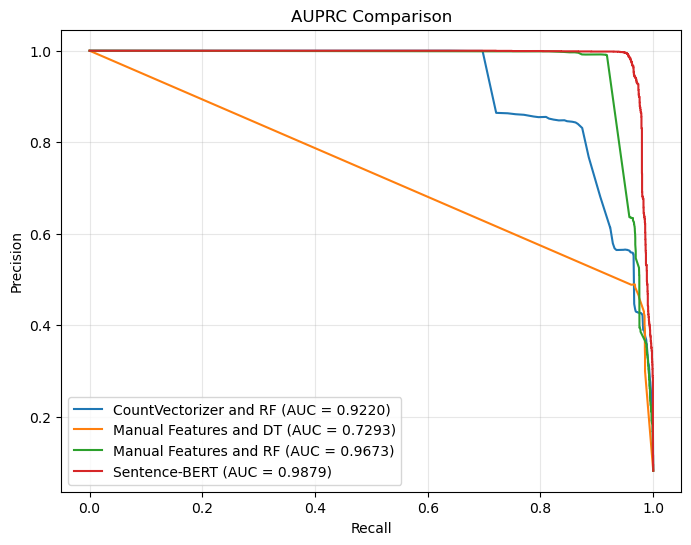

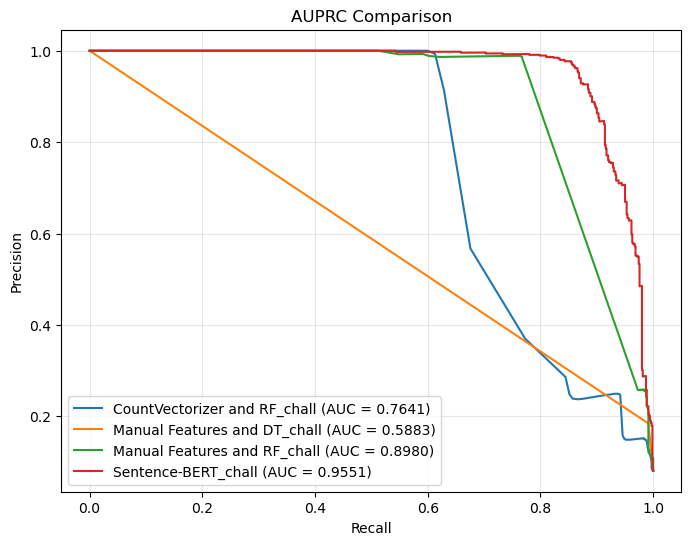

In [31]:
plot_pr_curves_from_dict(all_df,output_folder_path=folder_path,suffix="")
plot_pr_curves_from_dict(chall_df,output_folder_path=folder_path,suffix="_chall")

## AUROC

In [ ]:
folder_path = "./models/output/roc_curves"
folder_path = "/home/gquetel/experiences-results/dataset-generation/v1/output/roc_curves"

def plot_roc_curves_from_dict(
    dataframes_dict: dict,
    output_folder_path="./models/output/roc_curves/",
    suffix: str = "",
):
    fig, ax = plt.subplots(figsize=(8, 6))

    folder_path = Path(output_folder_path)
    folder_path.mkdir(exist_ok=True, parents=True)

    for filename, df in dataframes_dict.items():
        model_name = filename.replace(".csv", "")

        fpr = df["fpr"].values
        tpr = df["tpr"].values

        auprc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auprc:.4f})")

    ax.plot([0, 1], [0, 1], "k--", alpha=0.6, label="Random Classifier")


    # Customize plot
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("AUPRC Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Save plot
    output_filename = f"auroc_curves{suffix}.png"
    plt.savefig(folder_path / output_filename, dpi=300, bbox_inches="tight")
    plt.show()

In [33]:
folder_path = "/home/gquetel/experiences-results/dataset-generation/v1/output/roc_curves"

d = load_csv_files(folder_path=folder_path)
chall_df = {}
all_df = {}

for filename, df in d.items():
    # Remove .csv extension for checking
    base_name = filename.replace(".csv", "")

    if base_name.endswith("_chall"):
        chall_df[filename] = df
    else:
        all_df[filename] = df

Loaded: CountVectorizer and RF.csv - Shape: (175, 2)
Loaded: CountVectorizer and RF_chall.csv - Shape: (124, 2)
Loaded: Manual Features and DT.csv - Shape: (28, 2)
Loaded: Manual Features and DT_chall.csv - Shape: (4, 2)
Loaded: Manual Features and RF.csv - Shape: (980, 2)
Loaded: Manual Features and RF_chall.csv - Shape: (532, 2)
Loaded: Sentence-BERT.csv - Shape: (3832, 2)
Loaded: Sentence-BERT_chall.csv - Shape: (600, 2)


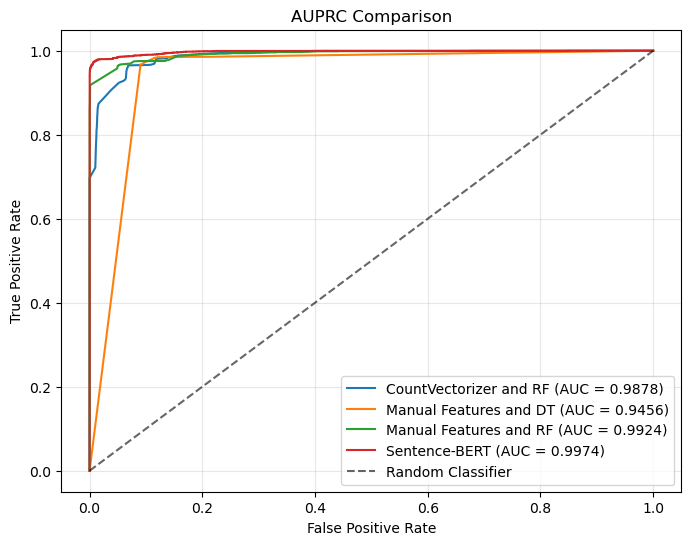

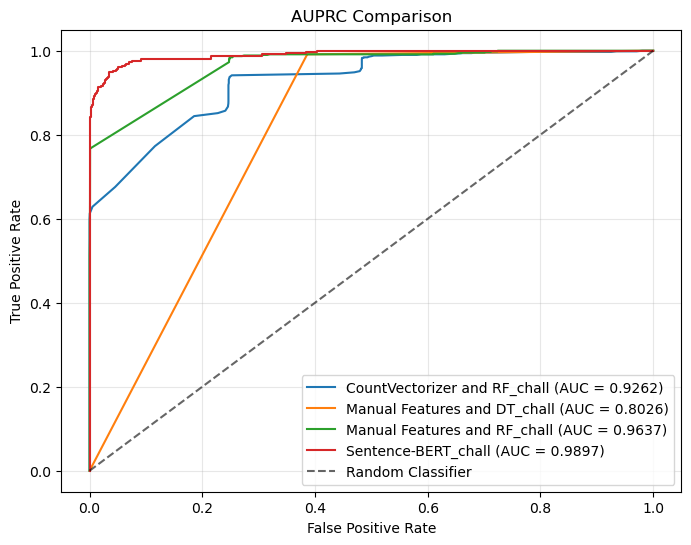

In [34]:
plot_roc_curves_from_dict(all_df,output_folder_path=folder_path,suffix="")
plot_roc_curves_from_dict(chall_df,output_folder_path=folder_path,suffix="_chall")